# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics


from importlib import reload

# Cargar data

- cargo

In [ ]:
df_data = pd.read_csv('./ds_pb_toTrain.csv', index_col=[0])
df_raw_data = pd.read_csv('./ds_pb.csv', index_col=[0])

# Preprocesamiento rápido

- Resuelvo problemas con descriptores que tienen infinitos

- Elimino nulos sí o sí (la otra alternativa sería imputar)

# Split target y patrón

- Split

In [ ]:
df_data.columns

Index(['Ferroelectric_Tc_in_Kelvin', 'Tolerance_Factor',
       'Ionic_Displacements'],
      dtype='object')

In [ ]:
x = df_data.drop(["Ferroelectric_Tc_in_Kelvin"], axis=1)
y = df_data['Ferroelectric_Tc_in_Kelvin']

- Validación

In [ ]:
print(x.shape)
print(y.shape)

(132, 2)
(132,)


# Split train y test

- Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=12, shuffle = True)

- Validación

In [ ]:
print(X_train.shape)
print(X_test.shape)

(105, 2)
(27, 2)


# Escalamiento/Normalización de los datos 

- Instancio scaler para target y patron

In [ ]:
x_st_scaler = StandardScaler() #Creo instancia del scaler
y_st_scaler = StandardScaler() #Creo instancia del scaler

- Escalo con fit sobre train, y trasnformo test

In [ ]:
X_train = x_st_scaler.fit_transform(X_train) # escalo train
X_test = x_st_scaler.transform(X_test) #transformo test

In [ ]:
y_train = y_st_scaler.fit_transform(y_train.values.reshape(-1,1)) # escalo train
y_test = y_st_scaler.transform(y_test.values.reshape(-1,1)) #transformo test

# Entrenamiento del modelo con Volting Regressor

- Importo

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

- Entreno y predigo

In [ ]:
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()

model = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_voting.py:600: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


- Evaluacióon rápida

In [ ]:
mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("r2 ", r2.round(4))
print("mse: ", mse.round(4))

r2  0.8585
mse:  0.254


- Residuales

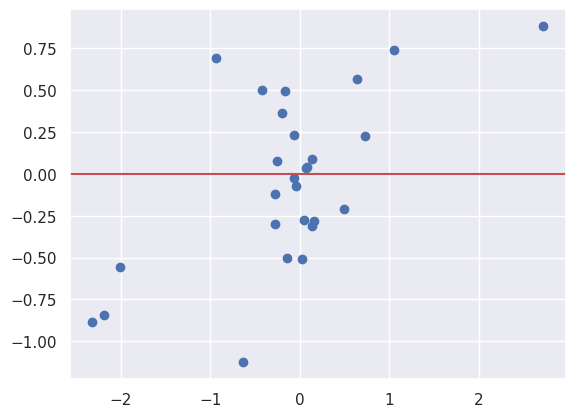

In [ ]:
residuals = np.subtract(y_test.reshape(-1), y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Entrenamiento del modelo con AdaBoost

- Importo

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

- Entreno y predigo

In [ ]:
model = AdaBoostRegressor(random_state=0, n_estimators=100)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


- Evaluacióon rápida

In [ ]:
mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("r2 ", r2.round(4))
print("mse: ", mse.round(4))

r2  0.8772
mse:  0.2205


- Residuales

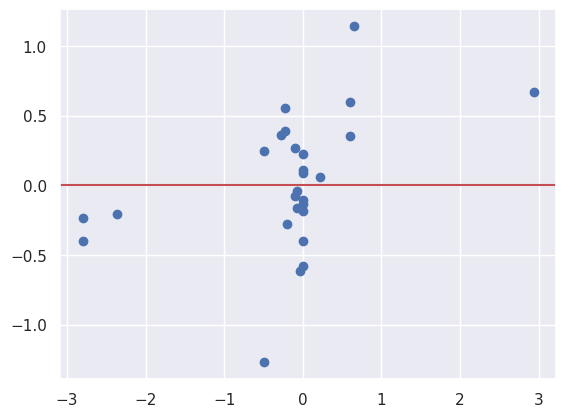

In [ ]:
residuals = np.subtract(y_test.reshape(-1), y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

- Unscale de las predicciones, para comprobar la validez del modelo

In [ ]:
predictions = y_st_scaler.inverse_transform(y_pred.reshape(-1,1))
predictions.max()

1034.5656

In [ ]:
real_tc_trainingSet = y_st_scaler.inverse_transform(y_test.reshape(-1,1))
real_tc_trainingSet.max()

1100.543

In [ ]:
features = x_st_scaler.inverse_transform(X_test)

- Performance (prediction vs measured values)

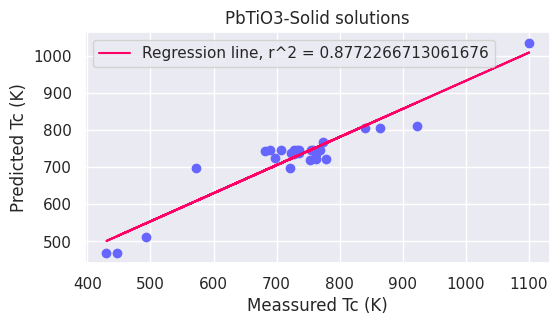

In [ ]:
from sklearn.linear_model import LinearRegression

regressionRealVsPred = LinearRegression()
regressionRealVsPred.fit(real_tc_trainingSet,predictions)
predictionLine = regressionRealVsPred.predict(real_tc_trainingSet)

r2 = metrics.r2_score(real_tc_trainingSet, predictions)

plt=reload(plt)
fig = plt.figure(figsize = (6, 3))

plt.plot(real_tc_trainingSet, predictionLine, color='#ff0066', label = f'Regression line, r^2 = {r2}')
plt.scatter(real_tc_trainingSet,predictions, color = '#6666ff')
plt.xlabel('Meassured Tc (K)')
plt.ylabel('Predicted Tc (K)')
plt.title('PbTiO3-Solid solutions')
plt.legend();
plt.show()

# Optimal Experimental Desing

- E(I) - Expected Improvement - computing for each predicted sample

E(I) -  probabilidad de mejorar los valores estimados a partir del muestreo usando incertezas en los valores estimados del target.
\begin{equation}
E(I) = \sigma (\phi(z) + z \Phi(z)
\end{equation}

donde $\phi(z)$ es la densidad normal estándarizada (satandar normal density) y $\Phi(z)$ es la función de distribución acumulada (cumulative distribution function).

\begin{eqnarray}
\phi(z) & = & \frac{1}{\sqrt{2\pi}} e^{-z^2/2} \\
\Phi(z) & = & \frac{1}{\sqrt{2\pi}} \int^z_{\infty} e^{-t^2/2}dt 
\end{eqnarray}

<img src="image-20231005-123329.png" width="" align="" />

z = (u-u*)/sigma;
   μ is the mean value or predicted response from the ML models,
   μ* is the maximum value observed in the current training set

In [ ]:
from scipy.stats import norm

eiList = [] #E(I) empty array to store its calculation on each prediction

mu_asterisk = real_tc_trainingSet.max()# maximum value observed in the current training set
std = np.std(predictions.reshape(-1)) #standard devation from the predicted response?

for prediction in predictions.reshape(-1):

    mu = prediction #each predicted response

    #z =  1.5# Replace with the desired value of z = (u-u*)/sigma
    z = (mu - mu_asterisk)/std
    #print(f"The CDF value of standard normal at z = {z} is: {cdf_value}")

    cdf_value = norm.cdf(z) #cumulative distribution function
    snm_value = norm.pdf(z) #standard normal density

    ei = std * ((snm_value) + (z*cdf_value))

    eiList.append(ei)

#eiList

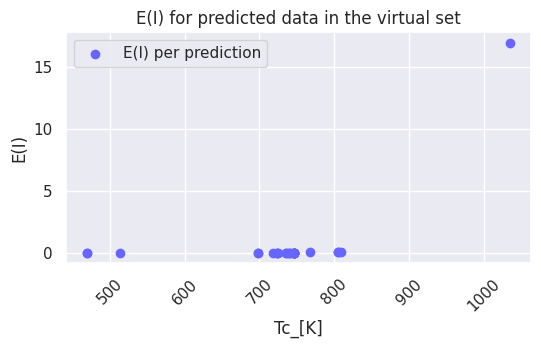

In [ ]:
plt=reload(plt)

fig = plt.figure(figsize = (6, 3))

plt.scatter(predictions.reshape(-1), eiList, color= '#6666ff',  label= 'E(I) per prediction')

 
plt.xlabel('Tc_[K]')
plt.ylabel("E(I)")
plt.title("E(I) for predicted data in the virtual set")
plt.legend(loc = 0, scatterpoints = 1)
plt.xticks(rotation=45)
plt.show()

- Verify the prediction which optimizes E(I)

In [ ]:
eiListNp = np.array(eiList)
predictedTargetFeatures = features[eiListNp.argmax()]
filteredTarget = ((df_raw_data.Tolerance_Factor == predictedTargetFeatures[0]) & (df_raw_data.Ionic_Displacements == predictedTargetFeatures[1]))
df_raw_data[filteredTarget]

,Compound,xBi(Me1Me2)O3,xPT,Tolerance_Factor,Ionic_Displacements,Ferroelectric_Tc_in_Kelvin
7,BiFeO3-PT,0.898,0.102,0.973697,0.129287,1100.543


- Con método exploitation

In [ ]:
df_raw_data.columns

Index(['Compound', 'xBi(Me1Me2)O3', 'xPT', 'Tolerance_Factor',
       'Ionic_Displacements', 'Ferroelectric_Tc_in_Kelvin'],
      dtype='object')

In [ ]:
predictedTargetFeatures = features[predictions.argmax()]
filteredTarget = ((df_raw_data.Tolerance_Factor == predictedTargetFeatures[0]) & (df_raw_data.Ionic_Displacements == predictedTargetFeatures[1]))
df_raw_data[filteredTarget]

,Compound,xBi(Me1Me2)O3,xPT,Tolerance_Factor,Ionic_Displacements,Ferroelectric_Tc_in_Kelvin
7,BiFeO3-PT,0.898,0.102,0.973697,0.129287,1100.543


- 

In [ ]:
a = pd.DataFrame(features, columns=[""])
a

ValueError: Shape of passed values is (27, 2), indices imply (27, 1)

In [ ]:
1plt=reload(plt)

fig = plt.figure(figsize = (6, 3))

plt.scatter(predictions.reshape(-1), eiList, color= '#6666ff',  label= 'E(I) per prediction')

 
plt.xlabel('Tc_[K]')
plt.ylabel("E(I)")
plt.title("E(I) for predicted data in the virtual set")
plt.legend(loc = 0, scatterpoints = 1)
plt.xticks(rotation=45)
plt.show()

# Random forest 

En el código que sigue se  toman diferentes datos de entrenamiento   (escogidos aleatoriamente) y se usa gridsearch para optimizar los hiperparámetros, luego se selecciona el mejor modelo (aquella división del conjunto de entrenamiento y prueba para la que se minimiza el error MSE en el conjunto de prueba) y con ese se hacen las predicciones. Al final se calcula I(E) usando los valores predichos por el algoritmo de un conjunto de validación (datos no usados en el entrenamiento ni en el conjunto de prueba). 

Para que funcione bien el código debes definir antes:

- x, y

- x_val,  y_val 

In [ ]:
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn.pipeline import make_pipeline 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
df_data.columns

Index(['Ferroelectric_Tc_in_Kelvin', 'Tolerance_Factor',
       'Ionic_Displacements'],
      dtype='object')

In [ ]:
df_dataSelect = df_data[df_data['Ferroelectric_Tc_in_Kelvin']>1100]
df_dataSelect.shape

(1, 3)

In [ ]:
x_train, x_val, y_train, y_val  = train_test_split(x, y, test_size=0.8, random_state=1) #Conjunto de validación se irá adicionando 




In [ ]:
#u: valor predicho (test) - uc* - máx. value en el set de entrenamiento - sigma - std del valor predicho (test)
from scipy.stats import norm
def IE(u,uc,sigma) :
    z=(u-uc)/sigma
    phi=(1/np.sqrt(2*np.pi))*(np.exp(-z**2/2.0))
    Phi=norm.cdf(z)
   # print("phi ", phi,"Phi \t", Phi)
    return sigma*(phi+z*Phi)
 

In [ ]:
def perform_grid_search(x_train, y_train, x_test, y_test,models,metrics):
    scaler = StandardScaler()
    
    results_df = pd.DataFrame(columns=['Model', 'Parameter Grid', 'Metric', 'Value','Estimators'])


    for name, model, param_grid in models: #Separa la inf. en models en nombre, modelo y parámetros
        print(f"Grid search for {name}")
        for metric, metric_func in metrics.items(): # Separa el nombre de la métrica y su función
            print(f"Evaluating using metric: {metric}")
            pipeline = Pipeline([('Scaler', scaler), ('grid_search',GridSearchCV(model, param_grid, 
            scoring=metric, cv=5, n_jobs=-1))])
            best_model = pipeline.fit(x_train, y_train)

            y_pred = pipeline.predict(x_test) # da igual que best_model.predict(x_test)
            y_pred_train = pipeline.predict(x_train)
            metric_value = metric_func(y_test, y_pred)
            r2=r2_score(y_test, y_pred)
            print(f"Test {metric} with best model: {metric_value}")
            print("===================================")
            print(f"Test r2: {r2}")

            #modelsGS.append(best_model)
           # metricsGS.append({metric_name, metric_value})

            results_df = results_df.append({
                'Model': name,
                'Parameter Grid': best_model.named_steps['grid_search'].best_params_,
                'Metric': metric,
                'MetricValue': metric_value,
                'r2': r2,
                'Estimators': best_model.named_steps['grid_search'].best_estimator_.estimators_,
                'PredicTest': y_pred,
                'PredicTrain': y_pred_train,
            }, ignore_index=True)

    return results_df

In [ ]:
rfr_param_grid = {'n_estimators': np.arange(50, 400, 50), 'max_depth': [None,np.arange(5, 50, 5)],
#                   'max_features': [1,5,10,'auto', 'sqrt'],
#                  'min_samples_split': [1,2,3,4, 5],
#                   'min_samples_leaf': [1, 2, 3,4,5]
                 }


metrics = {'neg_mean_squared_error': mean_squared_error }

Results_RF={}
ResultadosTotales={}
for k in range(1): # Veces que se repite el conjunto de entrenamiento
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.20, random_state = 42+k) #Siempre misma separación
    rfr = RandomForestRegressor(random_state=42)
    models = [ ('RFR', rfr, rfr_param_grid) ]
    resultado_GS = perform_grid_search(x_train, y_train, x_test, y_test,models,metrics)
    ResultadosTotales['k='+str(k)]=resultado_GS
    #Predicted values for each stimator in RF 
    scaler=StandardScaler()
    scaler.fit(x_train)

    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    x_val_scaled = scaler.transform(x_val)

    predTrain_per_estimator = pd.DataFrame()
    predTest_per_estimator = pd.DataFrame()
    predVal_per_estimator = pd.DataFrame()

      
    
    # Valores máximos en conjunto de entrenamiento:
    indx5 = y_train.idxmax() #Índice del valor max en training set
    uc= y_train[indx5]      #Valor máx en conjunto de entrenamiento

    
    for i,estimator in enumerate(resultado_GS['Estimators'][0]):
        # Make predictions using the current estimator
        print('Estimator', estimator)
        y_pred = estimator.predict(x_test_scaled)  
        y_pred_val = estimator.predict(x_val_scaled)
        y_pred_train = estimator.predict(x_train_scaled)
        # Append the predictions to the list
        predTrain_per_estimator[i]=y_pred_train 
        predTest_per_estimator[i]=y_pred  
        predVal_per_estimator[i]=y_pred_val #Dataset for all      
        
    
    mean_test=predTest_per_estimator.mean(axis=1)
    mean_train=predTrain_per_estimator.mean(axis=1)
    mean_val=predVal_per_estimator.mean(axis=1)
    std_test=predTest_per_estimator.std(axis=1)
    std_train=predTrain_per_estimator.std(axis=1)
    std_val=predVal_per_estimator.std(axis=1)
    r2_test=r2_score(y_test, mean_test)
    r2_train=r2_score(y_train, mean_train)
    
    
    
    
    Mean=pd.concat([mean_test,mean_val], ignore_index=True)
    Std=pd.concat([std_test,std_val], ignore_index=True)
    ie= IE(Mean,uc,Std)
    
    
    metrica=resultado_GS['MetricValue'][0]#Valor de métrica arrojada por GridSearchCV : valor medio de CV en el mejor estimador: en test set
    Results_RF['k='+str(k)]={'mean_test': mean_test, 
                             'mean_train': mean_train,
                             'mean_val': mean_val,
                             'std_test': std_test,
                             'std_train': std_train,
                             'std_va': std_val,
                             'metrica': metrica,
                             'r2_test': r2_test,
                             'r2_train':r2_train,
                             'y_test':y_test,
                             'y_train':y_train,
                             'ie': ie
    }
    

Grid search for RFR
Evaluating using metric: neg_mean_squared_error
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 476, in fit
    trees = Parallel(
  File "/shared-libs/python3.9/py/lib/python3.9/site-packages/joblib/parallel.py", line 1

In [ ]:
#Selecciona el mejor resultado en el test set
Results_RF
#Encuentra la etiqueta de los datos con menor MSE en el test set
max_key = min(Results_RF, key=lambda k: Results_RF[k]['metrica'])
max_key

'k=0'

Text(0, 0.5, 'Predictions [Tc] $(K)$')

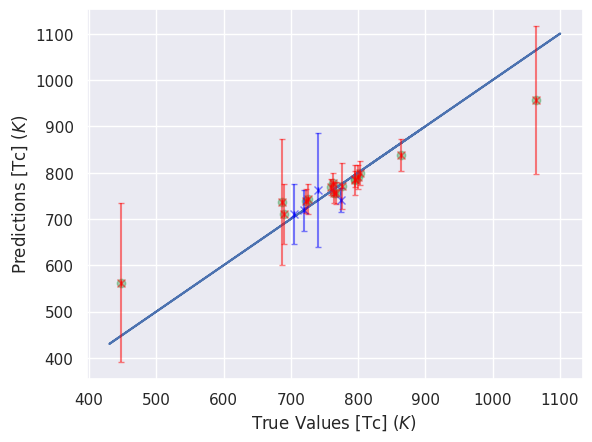

In [ ]:
plt.scatter(Results_RF[max_key]['y_train'],Results_RF[max_key]['mean_train'],c='g', alpha=0.5)
#plt.scatter(y_val,Results_RF[max_key]['mean_val'],c='black', alpha=0.7)
plt.plot(y,y)
plt.errorbar(Results_RF[max_key]['y_test'], Results_RF[max_key]['mean_test'], xerr=0.0, yerr=std_test, linestyle="None",capsize=2, fmt="x",c='blue',alpha=0.5)
plt.errorbar(Results_RF[max_key]['y_train'], Results_RF[max_key]['mean_train'], xerr=0.0, yerr=std_train, linestyle="None",capsize=2, fmt="x",c='red',alpha=0.5)
plt.xlabel('True Values [Tc] $(K)$ ')
plt.ylabel('Predictions [Tc] $(K)$')

In [ ]:
#Calculate Improvement I(E)
uc=Results_RF[max_key]['y_train'].max() #Válido para H=5
u=Results_RF[max_key]['mean_val']  #Set de validación: datos ocultos al algoritmo.
sigma=std_val
ie= IE(u,uc,sigma)
ie

0      1.527005e-11
1      3.764932e-02
2      2.543842e-38
3      1.594710e+01
4      4.492170e-01
           ...     
101    3.997907e-79
102    2.859683e-03
103    2.469689e+01
104    9.003425e-25
105    1.090724e+00
Length: 106, dtype: float64

In [ ]:
ie.max()

24.696894842366806

In [ ]:
ie.idxmax()

103

# Random forest : adicionando datos con mayor IE

Código similar al anterior pero va adicionando al conjunto de entrenamiento los datos que tienen el mayor Improvement I(E)

Para que funcione correctamente rquiere:

- x,y 

- - x_val, y_val: datos ocultos que se irán adicionando al conjunto d eentrenamiento.

In [ ]:
rfr_param_grid = {'n_estimators': np.arange(50, 200, 50), 'max_depth': [None,np.arange(5, 50, 5)],
                  'max_features': [1,5,10,'auto', 'sqrt'],
#                  'min_samples_split': [1,2,3,4, 5],
#                   'min_samples_leaf': [1, 2, 3,4,5]
                 }


metrics = {'neg_mean_squared_error': mean_squared_error }

Results_RF={}
ResultadosTotales={}
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.70, random_state = 42) #Siempre misma separación
print('Initial size: ', y_train.shape)
for k in range(20): # Se adicionan 20 nuevos datos al conjunto de entrenamiento
      
    rfr = RandomForestRegressor(random_state=42)
    models = [ ('RFR', rfr, rfr_param_grid) ]
    resultado_GS = perform_grid_search(x_train, y_train, x_test, y_test,models,metrics)
    ResultadosTotales['k='+str(k)]=resultado_GS
    #Predicted values for each stimator in RF 
    scaler=StandardScaler()
    scaler.fit(x_train)

    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    x_val_scaled = scaler.transform(x_val)

    predTrain_per_estimator = pd.DataFrame()
    predTest_per_estimator = pd.DataFrame()
    predVal_per_estimator = pd.DataFrame()
    
   
    
    
    
    
    
    for i,estimator in enumerate(resultado_GS['Estimators'][0]):
        # Make predictions using the current estimator
        print('Estimator', estimator)
        y_pred = estimator.predict(x_test_scaled)  # Replace X_test with your test data
        y_pred_val = estimator.predict(x_val_scaled)
        y_pred_train = estimator.predict(x_train_scaled)
        # Append the predictions to the list
        predTrain_per_estimator[i]=y_pred_train 
        predTest_per_estimator[i]=y_pred  
        predVal_per_estimator[i]=y_pred_val #Dataset for all 
        
         
        
    
    mean_test=predTest_per_estimator.mean(axis=1)
    mean_train=predTrain_per_estimator.mean(axis=1)
    mean_val=predVal_per_estimator.mean(axis=1)
    std_test=predTest_per_estimator.std(axis=1)
    std_train=predTrain_per_estimator.std(axis=1)
    std_val=predVal_per_estimator.std(axis=1)
    r2_test=r2_score(y_test, mean_test)
    r2_train=r2_score(y_train, mean_train)

    

    uc1=y_train.max()
    ieHTest= IE(mean_test,uc1,std_test)
    ieHVal= IE(mean_val,uc1,std_val)
    
    max_indexVal= ieHVal.idxmax()
    max_indexTest= ieHTest.idxmax()
    
    
    y_train2=y_train.copy()
    y_test2=y_test.copy()
    
    metrica=resultado_GS['MetricValue'][0]#Valor de métrica arrojada por GridSearchCV : valor medio de CV en el mejor estimador: en test set
    Results_RF['k='+str(k)]={'mean_test': mean_test, 
                             'mean_train': mean_train,
                             'mean_val': mean_val,
                             'std_test': std_test,
                             'std_train': std_train,
                             'std_va': std_val,
                             'metrica': metrica,
                             'r2_test': r2_test,
                             'r2_train':r2_train,
                             'y_test':y_test2,
                             'y_train':y_train2,
                             'ieHTest': ieHTest,
                             'ieHVal': ieHVal,
    }
    
    x_train.loc[len(y_train)] =  x_test.reset_index(drop=True).iloc[max_indexTest]   
    y_train.loc[len(y_train)] =  y_test.reset_index(drop=True).iloc[max_indexTest]
    print('Size train:', y_train.shape)
    
    y_test=y_test.reset_index(drop=True).drop(max_indexTest)
    x_test=x_test.reset_index(drop=True).drop(max_indexTest)

Estimator DecisionTreeRegressor(max_features=5, random_state=249467210)
Estimator DecisionTreeRegressor(max_features=5, random_state=1972458954)
Estimator DecisionTreeRegressor(max_features=5, random_state=1572714583)
Estimator DecisionTreeRegressor(max_features=5, random_state=1433267572)
Estimator DecisionTreeRegressor(max_features=5, random_state=434285667)
Estimator DecisionTreeRegressor(max_features=5, random_state=613608295)
Estimator DecisionTreeRegressor(max_features=5, random_state=893664919)
Estimator DecisionTreeRegressor(max_features=5, random_state=648061058)
Estimator DecisionTreeRegressor(max_features=5, random_state=88409749)
Estimator DecisionTreeRegressor(max_features=5, random_state=242285876)
Estimator DecisionTreeRegressor(max_features=5, random_state=2018247425)
Estimator DecisionTreeRegressor(max_features=5, random_state=953477463)
Estimator DecisionTreeRegressor(max_features=5, random_state=1427830251)
Estimator DecisionTreeRegressor(max_features=5, random_state

In [ ]:
#Encuentra la etiqueta de los datos con mayor r2OOb: train set con mayor número de datos
max_key = min(Results_RF, key=lambda k: Results_RF[k]['metrica'])
max_key

'k=18'

Text(0, 0.5, 'Predictions Tc] $(K)$')

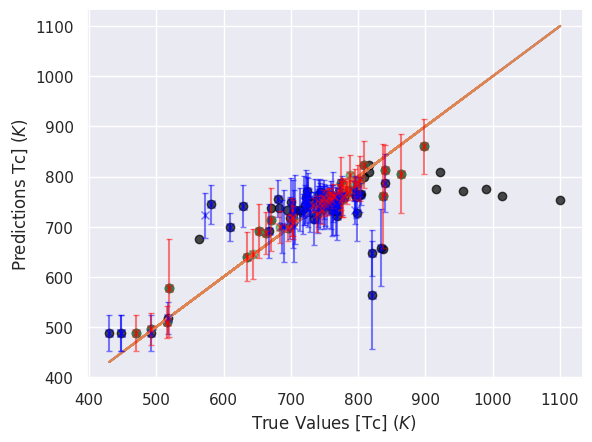

In [ ]:
plt.scatter(Results_RF[max_key]['y_train'], Results_RF[max_key]['mean_train'],c='g', alpha=0.5)
plt.scatter(y_val,Results_RF[max_key]['mean_val'],c='black', alpha=0.7)
plt.plot(y,y)
plt.plot(y_val,y_val)
plt.errorbar(Results_RF[max_key]['y_test'], Results_RF[max_key]['mean_test'], xerr=0.0, yerr=Results_RF[max_key]['std_test'], linestyle="None",capsize=2, fmt="x",c='blue',alpha=0.5)
plt.errorbar(Results_RF[max_key]['y_train'], Results_RF[max_key]['mean_train'], xerr=0.0, yerr=Results_RF[max_key]['std_train'], linestyle="None",capsize=2, fmt="x",c='red',alpha=0.5)
plt.scatter(Results_RF[max_key]['y_train'], Results_RF[max_key]['mean_train'],c='g', alpha=0.5)
plt.xlabel('True Values [Tc] $(K)$ ')
plt.ylabel('Predictions Tc] $(K)$')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1238d720-2ec8-40e1-ad99-9d2cd1c1fe59' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>